# 1.环境准备与参数配置

In [1]:
# # 金庸小说语义分析系统
# 功能模块：
# - 多文本自动加载
# - 精准实体识别（人物/门派/武功）
# - Word2Vec词向量训练
# - 三维语义可视化

# ## 参数配置区
# 在此配置路径和模型参数

# 
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
import jieba
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ===== 新增检查点控制标志 =====
LOAD_CHECKPOINT = True  # 设置为True时加载检查点跳过训练

# ===== 用户配置 =====
CONFIG = {
    # 路径配置
    "novel_dir": "./novel",            # 小说存放目录
    "userwords_dir": "./userwords",    # 实体词典目录
    "inf_file": "inf.txt",             # 小说列表文件
    "entity_files": {                  # 实体词典文件
        "orgs": "金庸小说全门派.txt",
        "persons": "金庸小说全人物.txt", 
        "skills": "金庸小说全武功.txt",
        "stopwords": "stop_words.txt"
    },
    
    # 模型参数
    "embed_dim": 300,          # 词向量维度（建议128-512）
    "window_size": 5,          # 上下文窗口
    "min_word_count": 5,       # 最低词频
    "batch_size": 4096,        # 训练批大小
    "epochs": 15,              # 训练轮次
    
    # 可视化参数  
    "visual_topn": 150,        # 每类显示数量
    "label_fontsize": 8,       # 标签字号
    "marker_size": 40          # 点大小
}

# 检查GPU可用性
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前使用设备：{DEVICE}")


C:\Users\Zhou Liying\.conda\envs\env1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


当前使用设备：cpu


# 2.数据加载模块

In [2]:
# 实现：
# 1. 加载官方实体词典
# 2. 合并多本小说文本
# 3. 执行分词与清洗

# 
class DataLoader:
    def __init__(self, config):
        self.config = config
        self.entity_data = self._load_entity_dicts()
        self.corpus = self._load_corpus()
        self.vocab, self.idx2word = self._build_vocab()

    def _detect_encoding(self, file_path):
        """自动检测文件编码"""
        from chardet import detect
        with open(file_path, 'rb') as f:
            rawdata = f.read(10000)  # 读取前10000字节用于检测
            result = detect(rawdata)
        return result['encoding']

    
    def _load_entity_dicts(self):
        """加载实体词典和停用词（增强编码处理）"""
        entity_dicts = {}
        base_path = self.config['userwords_dir']
        
        # 加载实体词典（自动检测编码）
        for key, filename in self.config['entity_files'].items():
            if key == 'stopwords':
                continue
            
            file_path = os.path.join(base_path, filename)
            entity_dicts[key] = set()
            
            try:
                # 检测文件编码
                encoding = self._detect_encoding(file_path)
                with open(file_path, 'r', encoding=encoding, errors='replace') as f:
                    entity_dicts[key] = {line.strip() for line in f if line.strip()}
                print(f"✓ 成功加载 {filename}（编码：{encoding}）")
            except Exception as e:
                print(f"⚠ 尝试自动编码加载 {filename} 失败: {str(e)}")
                print("尝试GB18030编码回退...")
                try:
                    with open(file_path, 'r', encoding='gb18030', errors='replace') as f:
                        entity_dicts[key] = {line.strip() for line in f if line.strip()}
                    print(f"✓ 成功回退加载 {filename}（使用GB18030编码）")
                except Exception as e2:
                    print(f"✗ 终极加载失败: {str(e2)}")
                    entity_dicts[key] = set()
        
        # 加载停用词（兼容GB18030）
        stop_path = os.path.join(base_path, self.config['entity_files']['stopwords'])
        try:
            # 尝试UTF-8读取
            with open(stop_path, 'r', encoding='utf-8') as f:
                stopwords = {line.strip() for line in f if line.strip()}
        except UnicodeDecodeError:
            # 回退到GB18030
            with open(stop_path, 'r', encoding='gb18030') as f:
                stopwords = {line.strip() for line in f if line.strip()}
        entity_dicts['stopwords'] = stopwords
        print(f"✓ 加载停用词: {len(stopwords)} 条")
            
        return entity_dicts

    def _clean_text(self, text):
        """增强编码鲁棒性的文本清洗"""
        # 编码规范化处理
        try:
            text = text.encode('utf-8').decode('utf-8')
        except UnicodeDecodeError:
            text = text.encode('gb18030', errors='ignore').decode('gb18030', errors='ignore')
        
        # 移除特殊字符
        text = re.sub(r'[\u3000\xa0■◆●○★☆【】「」]+', '', text)
        # 合并重复标点
        return re.sub(r'([！？。，；：“”‘’（）])\1+', r'\1', text)

    def _tokenize(self, text):
        """实体保护的分词处理"""
        protected_phrases = (self.entity_data['persons'] | 
                            self.entity_data['orgs'] | 
                            self.entity_data['skills'])
        jieba.re_han_default = re.compile(f'({"|".join(protected_phrases)}|[\\w\\d]+)', re.UNICODE)
        
        return [
            word for sentence in jieba.cut(text)
            if (word := sentence.strip()) 
            and word not in self.entity_data['stopwords']
            and (len(word) > 1 or word in protected_phrases)
        ]

    def _load_novel(self, novel_name):
        """安全加载单本小说"""
        file_path = os.path.join(self.config['novel_dir'], f"{novel_name}.txt")
        if not os.path.exists(file_path):
            print(f"\n⚠ 文件缺失: {file_path}")
            return []
        
        try:
            # 自动检测编码
            encoding = self._detect_encoding(file_path)
            with open(file_path, "r", encoding=encoding, errors='replace') as f:
                text = f.read()
                text = self._clean_text(text)
                return self._tokenize(text)
        except Exception as e:
            print(f"\n⚠ 加载 {novel_name} 失败: {str(e)}")
            print("尝试备用编码方案...")
            try:
                # 备用编码尝试
                encodings = ['gb18030', 'gbk', 'big5', 'utf-16']
                for enc in encodings:
                    try:
                        with open(file_path, "r", encoding=enc, errors='replace') as f:
                            text = f.read()
                            text = self._clean_text(text)
                            return self._tokenize(text)
                    except:
                        continue
                print("所有编码尝试失败!")
                return []
            except Exception as e2:
                print(f"最终加载失败: {str(e2)}")
                return []

    def _load_corpus(self):
        """加载全部小说数据"""
        # 加载小说列表文件
        info_path = os.path.join(self.config['novel_dir'], self.config['inf_file'])
        try:
            # 检测inf.txt编码
            inf_encoding = self._detect_encoding(info_path)
            with open(info_path, "r", encoding=inf_encoding) as f:
                novel_names = [name.strip() for name in f.read().split(",") if name.strip()]
        except Exception as e:
            print(f"⚠ 加载小说列表失败: {str(e)}")
            print("尝试默认编码...")
            try:
                with open(info_path, "r", encoding='gb18030') as f:
                    novel_names = [name.strip() for name in f.read().split(",") if name.strip()]
            except:
                print("无法读取小说列表文件！")
                return []
        
        # 多线程加载小说内容
        from concurrent.futures import ThreadPoolExecutor
        corpus = []
        with ThreadPoolExecutor(max_workers=4) as executor:
            futures = []
            for name in novel_names:
                futures.append(executor.submit(self._load_novel, name))
            
            for future in tqdm(futures, desc="加载小说"):
                corpus += future.result()
        
        print(f"\n✅ 语料加载完成 | 总词数: {len(corpus):,} | 唯一词数: {len(set(corpus)):,}")
        return corpus

    def _build_vocab(self):
        """构建词汇表（修正索引分配）"""
        word_freq = defaultdict(int)
        for word in tqdm(self.corpus, desc="统计词频", unit=" words"):
            word_freq[word] += 1
        
        # 筛选有效词汇并按频率排序
        valid_words = [word for word, cnt in word_freq.items() 
                      if cnt >= self.config['min_word_count']]
        valid_words = sorted(valid_words, key=lambda x: word_freq[x], reverse=True)
        
        # 创建连续索引
        vocab = {word: idx for idx, word in enumerate(valid_words)}
        vocab["<UNK>"] = len(vocab)  # 添加未知词标记
        idx2word = {v: k for k, v in vocab.items()}
        
        print(f"📚 有效词汇表: {len(vocab):,} 词 (阈频 ≥{self.config['min_word_count']})")
        return vocab, idx2word


# 初始化数据加载器
print("="*40 + " 初始化数据加载 " + "="*40)
data_loader = DataLoader(CONFIG)

======================================== 初始化数据加载 ========================================
✓ 成功加载 金庸小说全门派.txt（编码：GB2312）
✓ 成功加载 金庸小说全人物.txt（编码：GB2312）
✓ 成功加载 金庸小说全武功.txt（编码：GB2312）
✓ 加载停用词: 1902 条


Building prefix dict from the default dictionary ...
加载小说:   0%|                                                                                 | 0/16 [00:00<?, ?it/s]Loading model from cache C:\Users\ZHOULI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.802 seconds.
Prefix dict has been built successfully.
加载小说: 100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.02s/it]



✅ 语料加载完成 | 总词数: 2,097,634 | 唯一词数: 152,609


统计词频: 100%|█████████████████████████████████████████████████████| 2097634/2097634 [00:00<00:00, 4038748.47 words/s]

📚 有效词汇表: 41,973 词 (阈频 ≥5)


# 3.模型定义与训练

In [3]:
# 包含：
# - Word2Vec模型结构
# - 训练流程管理

# %%
class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, x):
        embeds = self.embeddings(x)
        return self.linear(embeds)

class ModelTrainer:
    def __init__(self, config, data_loader):
        self.config = config
        self.data_loader = data_loader
        self.model = Word2VecModel(len(data_loader.vocab), config['embed_dim']).to(DEVICE)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        
    def generate_pairs(self):
        """生成训练样本对"""
        pairs = []
        window = self.config['window_size']
        corpus = self.data_loader.corpus
        vocab = self.data_loader.vocab
        
        for i in tqdm(range(window, len(corpus)-window), desc="生成样本"):
            target = vocab.get(corpus[i], vocab["<UNK>"])
            context = [
                vocab.get(corpus[j], vocab["<UNK>"])
                for j in range(i-window, i+window+1)
                if j != i
            ]
            pairs.extend((target, ctx) for ctx in context)
        
        print(f"生成训练样本：{len(pairs):,} 对")
        return pairs
    
    def train(self):
        """执行训练流程"""
        pairs = self.generate_pairs()
        dataset = torch.utils.data.TensorDataset(
            torch.LongTensor([p[0] for p in pairs]),
            torch.LongTensor([p[1] for p in pairs])
        )
        loader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=self.config['batch_size'], 
            shuffle=True
        )
        
        loss_history = []
        for epoch in range(self.config['epochs']):
            self.model.train()
            total_loss = 0
            
            for batch in tqdm(loader, desc=f"训练轮次 {epoch+1}/{self.config['epochs']}"):
                targets, contexts = batch[0].to(DEVICE), batch[1].to(DEVICE)
                
                self.optimizer.zero_grad()
                outputs = self.model(targets)
                loss = self.criterion(outputs, contexts)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(loader)
            loss_history.append(avg_loss)
            print(f"轮次 {epoch+1} 平均损失：{avg_loss:.4f}")

        
        
        # 绘制损失曲线
        plt.plot(range(1, len(loss_history)+1), loss_history, 'bo-')
        plt.xlabel('训练轮次')
        plt.ylabel('损失值')
        plt.title('训练损失变化曲线')
        plt.grid(True)
        plt.show()

        # 新增检查点保存
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epoch': self.config['epochs'],
            'loss_history': loss_history,
            'vocab': self.data_loader.vocab,
            'idx2word': self.data_loader.idx2word
        }
        torch.save(checkpoint, 'word2vec_checkpoint.pth')
        print(f"\n✅ 检查点已保存至 word2vec_checkpoint.pth")

if not LOAD_CHECKPOINT:
    print("\n" + "="*40 + " 开始模型训练 " + "="*40)
    trainer = ModelTrainer(CONFIG, data_loader)
    trainer.train()
else:
    print("\n" + "="*40 + " 加载检查点 " + "="*40)
    checkpoint = torch.load('word2vec_checkpoint.pth')
    model = Word2VecModel(len(checkpoint['vocab']), CONFIG['embed_dim']).to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    vocab = checkpoint['vocab']
    idx2word = checkpoint['idx2word']
    print("✅ 模型已从检查点加载")


======================================== 加载检查点 ========================================
✅ 模型已从检查点加载


# 4.实体识别模块

In [4]:
# 实现：
# 1. 精确词典匹配
# 2. 规则补充识别
# 3. 结果过滤

#
class EntityExtractor:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.corpus = data_loader.corpus
        self.entity_data = data_loader.entity_data
        
    def extract(self):
        """执行实体抽取"""
        persons, orgs, skills = self._exact_match()
        self._rule_based_extract(persons, orgs)
        return self._filter_results(persons, orgs, skills)
    
    def _exact_match(self):
        """精确匹配已知实体"""
        persons = defaultdict(int)
        orgs = defaultdict(int)
        skills = defaultdict(int)
        
        for word in tqdm(self.corpus, desc="精确匹配"):
            if word in self.entity_data['persons']:
                persons[word] += 1
            elif word in self.entity_data['orgs']:
                orgs[word] += 1
            elif word in self.entity_data['skills']:
                skills[word] += 1
        
        return persons, orgs, skills
    
    def _rule_based_extract(self, persons, orgs):
        """基于规则补充提取"""
        compound_surnames = {'欧阳','令狐','慕容','独孤','公孙','司徒','宇文'}
        org_suffix = tuple(self.entity_data['orgs'].union({'派','帮','门','教','岛','山庄'}))
        
        for i in tqdm(range(len(self.corpus)-1), desc="规则补充"):
            curr_word, next_word = self.corpus[i], self.corpus[i+1]
            
            if ((curr_word in compound_surnames and len(next_word) == 1) or 
                (len(curr_word) == 1 and curr_word in '张李王杨郭黄赵萧')):
                combined = curr_word + next_word
                if combined not in self.entity_data['persons']:
                    persons[combined] += 1
            
            if curr_word.endswith(org_suffix) and curr_word not in self.entity_data['orgs']:
                orgs[curr_word] += 1
    
    def _filter_results(self, persons, orgs, skills):
        """结果过滤"""
        return (
            {k for k, v in persons.items() if v >= 2} | self.entity_data['persons'],
            {k for k, v in orgs.items() if v >= 2} | self.entity_data['orgs'],
            self.entity_data['skills']
        )

print("\n" + "="*40 + " 开始实体抽取 " + "="*40)
extractor = EntityExtractor(data_loader)
persons, orgs, skills = extractor.extract()

print("\n实体统计：")
print(f"- 人物数量：{len(persons):,}（示例：{list(persons)[:5]}）")
print(f"- 门派数量：{len(orgs):,}（示例：{list(orgs)[:5]}）")
print(f"- 武功数量：{len(skills):,}（示例：{list(skills)[:5]}）")




======================================== 开始实体抽取 ========================================


规则补充: 100%|█████████████████████████████████████████████████████████| 2097633/2097633 [00:01<00:00, 1509016.42it/s]


实体统计：
- 人物数量：1,237（示例：['方有德', '单正', '朱九真', '戚长发', '包不同']）
- 门派数量：648（示例：['不帮', '单教', '一路派', '摩尼教', '家门']）
- 武功数量：388（示例：['袖里乾坤', '苗家剑法', '灵鳌步', '鹤形拳', '弹指神通']）


# 5.三维可视化模块

原始人物数量：1237
原始门派数量：648
原始武功数量：388
有效人物向量：1090
有效门派向量：331
有效武功向量：38


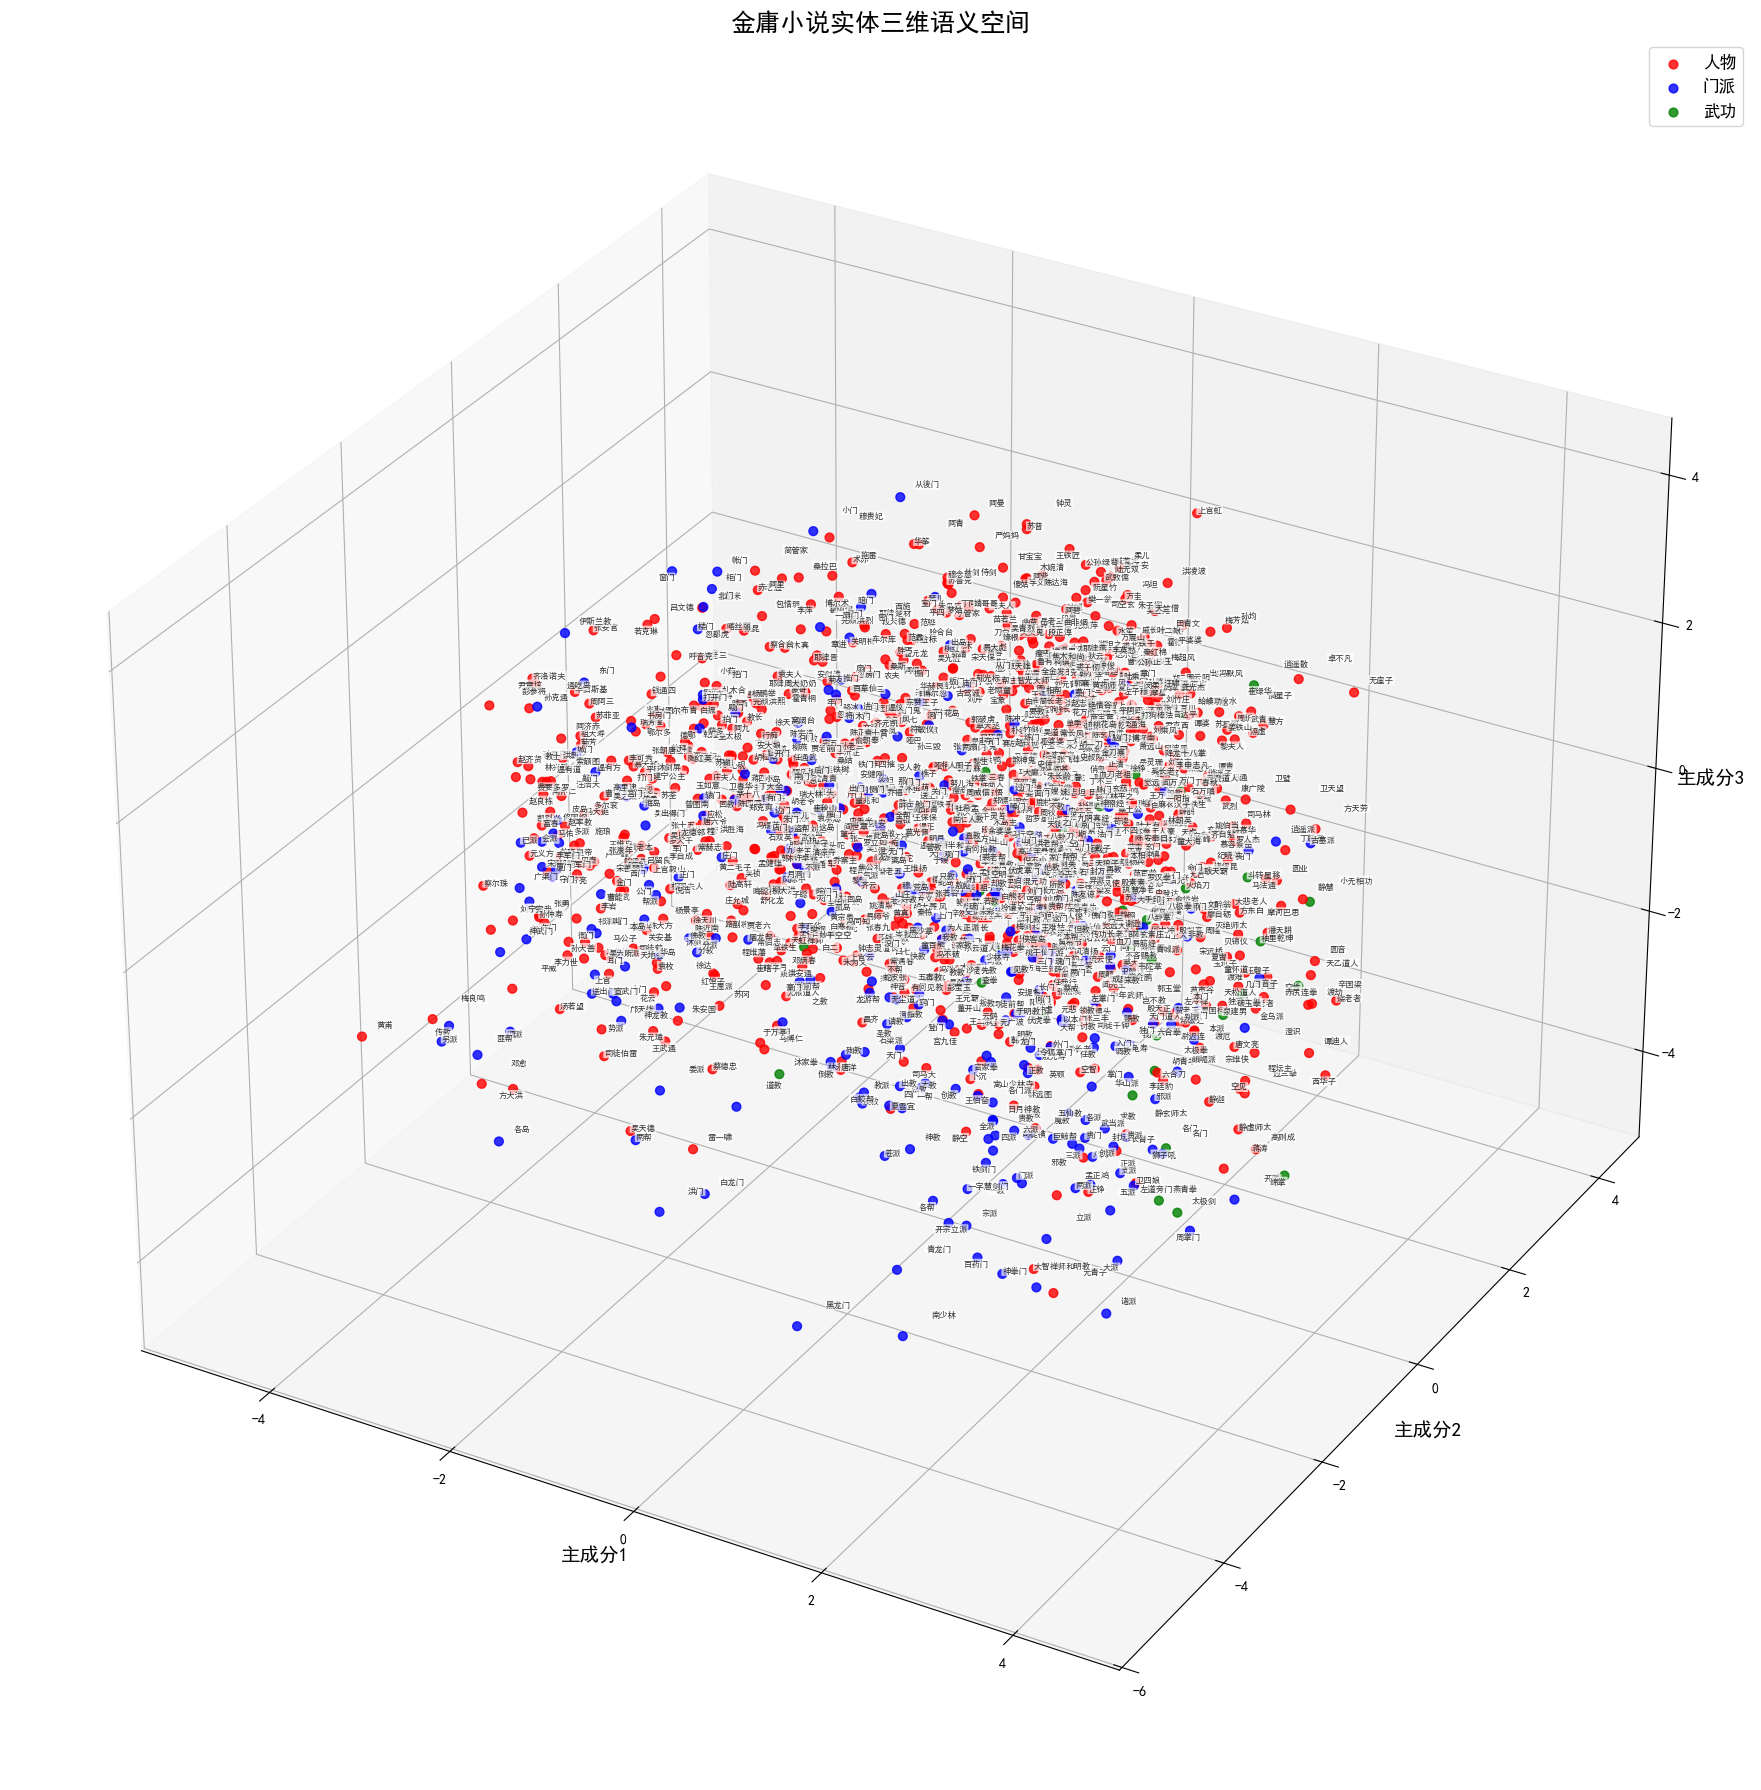

In [5]:
# ===== 新增三维可视化实现 =====
class PCAVisualizer:
    def __init__(self, config, model, vocab, entity_data):
        self.config = config
        self.model = model
        self.vocab = vocab
        self.entity_data = entity_data

    def get_embeddings(self, words):
        embeddings = []
        valid_words = []
        for word in words:
            if word in self.vocab:
                idx = torch.tensor([self.vocab[word]], device=DEVICE)
                embeddings.append(self.model.embeddings(idx).cpu().detach().numpy()[0])
                valid_words.append(word)
        return np.array(embeddings), valid_words

    def visualize_3d(self, persons, orgs, skills):
        # 打印原始实体数量
        print(f"原始人物数量：{len(persons)}")
        print(f"原始门派数量：{len(orgs)}")
        print(f"原始武功数量：{len(skills)}")
        
        # 获取词向量
        emb_p, words_p = self.get_embeddings(persons)
        emb_o, words_o = self.get_embeddings(orgs)
        emb_s, words_s = self.get_embeddings(skills)
        
        # 打印有效词向量数量
        print(f"有效人物向量：{len(words_p)}")
        print(f"有效门派向量：{len(words_o)}")
        print(f"有效武功向量：{len(words_s)}")
        
        # 合并数据
        all_emb = np.concatenate([emb_p, emb_o, emb_s])
        all_words = words_p + words_o + words_s
        colors = ['red']*len(words_p) + ['blue']*len(words_o) + ['green']*len(words_s)
        
        # 执行PCA降维
        pca = PCA(n_components=3)
        points = pca.fit_transform(all_emb)
        
        # 创建大尺寸画布
        fig = plt.figure(figsize=(24, 18))
        ax = fig.add_subplot(111, projection='3d')
        
        # 设置中文字体支持
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        
        # 绘制散点（分组绘制）
        categories = {
            '人物': (points[:len(words_p)], 'red'),
            '门派': (points[len(words_p):len(words_p)+len(words_o)], 'blue'),
            '武功': (points[-len(words_s):], 'green')
        }
        
        for label, (data, color) in categories.items():
            ax.scatter(data[:,0], data[:,1], data[:,2], 
                      c=color, label=label, 
                      s=self.config['marker_size'], alpha=0.8)
        
        # 优化标签显示（缩小字体+防重叠）
        for i, (x, y, z, word) in enumerate(zip(points[:,0], points[:,1], points[:,2], all_words)):
            # 动态偏移防止重叠
            offset = 0.1 * (i % 4 - 1)
            ax.text(x+offset, y+offset, z+offset, word, 
                    fontsize=6,
                    color='black',
                    alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.1',
                             facecolor='white', 
                             edgecolor='none',
                             alpha=0.7),
                    zorder=10)

        # 增强图表可读性
        ax.set_xlabel('主成分1', fontsize=14)
        ax.set_ylabel('主成分2', fontsize=14)
        ax.set_zlabel('主成分3', fontsize=14)
        plt.title('金庸小说实体三维语义空间', fontsize=18)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()



    
if LOAD_CHECKPOINT:
    visualizer = PCAVisualizer(CONFIG, model, vocab, data_loader.entity_data)
    visualizer.visualize_3d(persons, orgs, skills)
else:
    visualizer = PCAVisualizer(CONFIG, trainer.model, data_loader.vocab, data_loader.entity_data)
    visualizer.visualize_3d(persons, orgs, skills)

生成综合三维可视化...
原始人物数量：1237
原始门派数量：648
原始武功数量：388
有效人物向量：1090
有效门派向量：331
有效武功向量：38


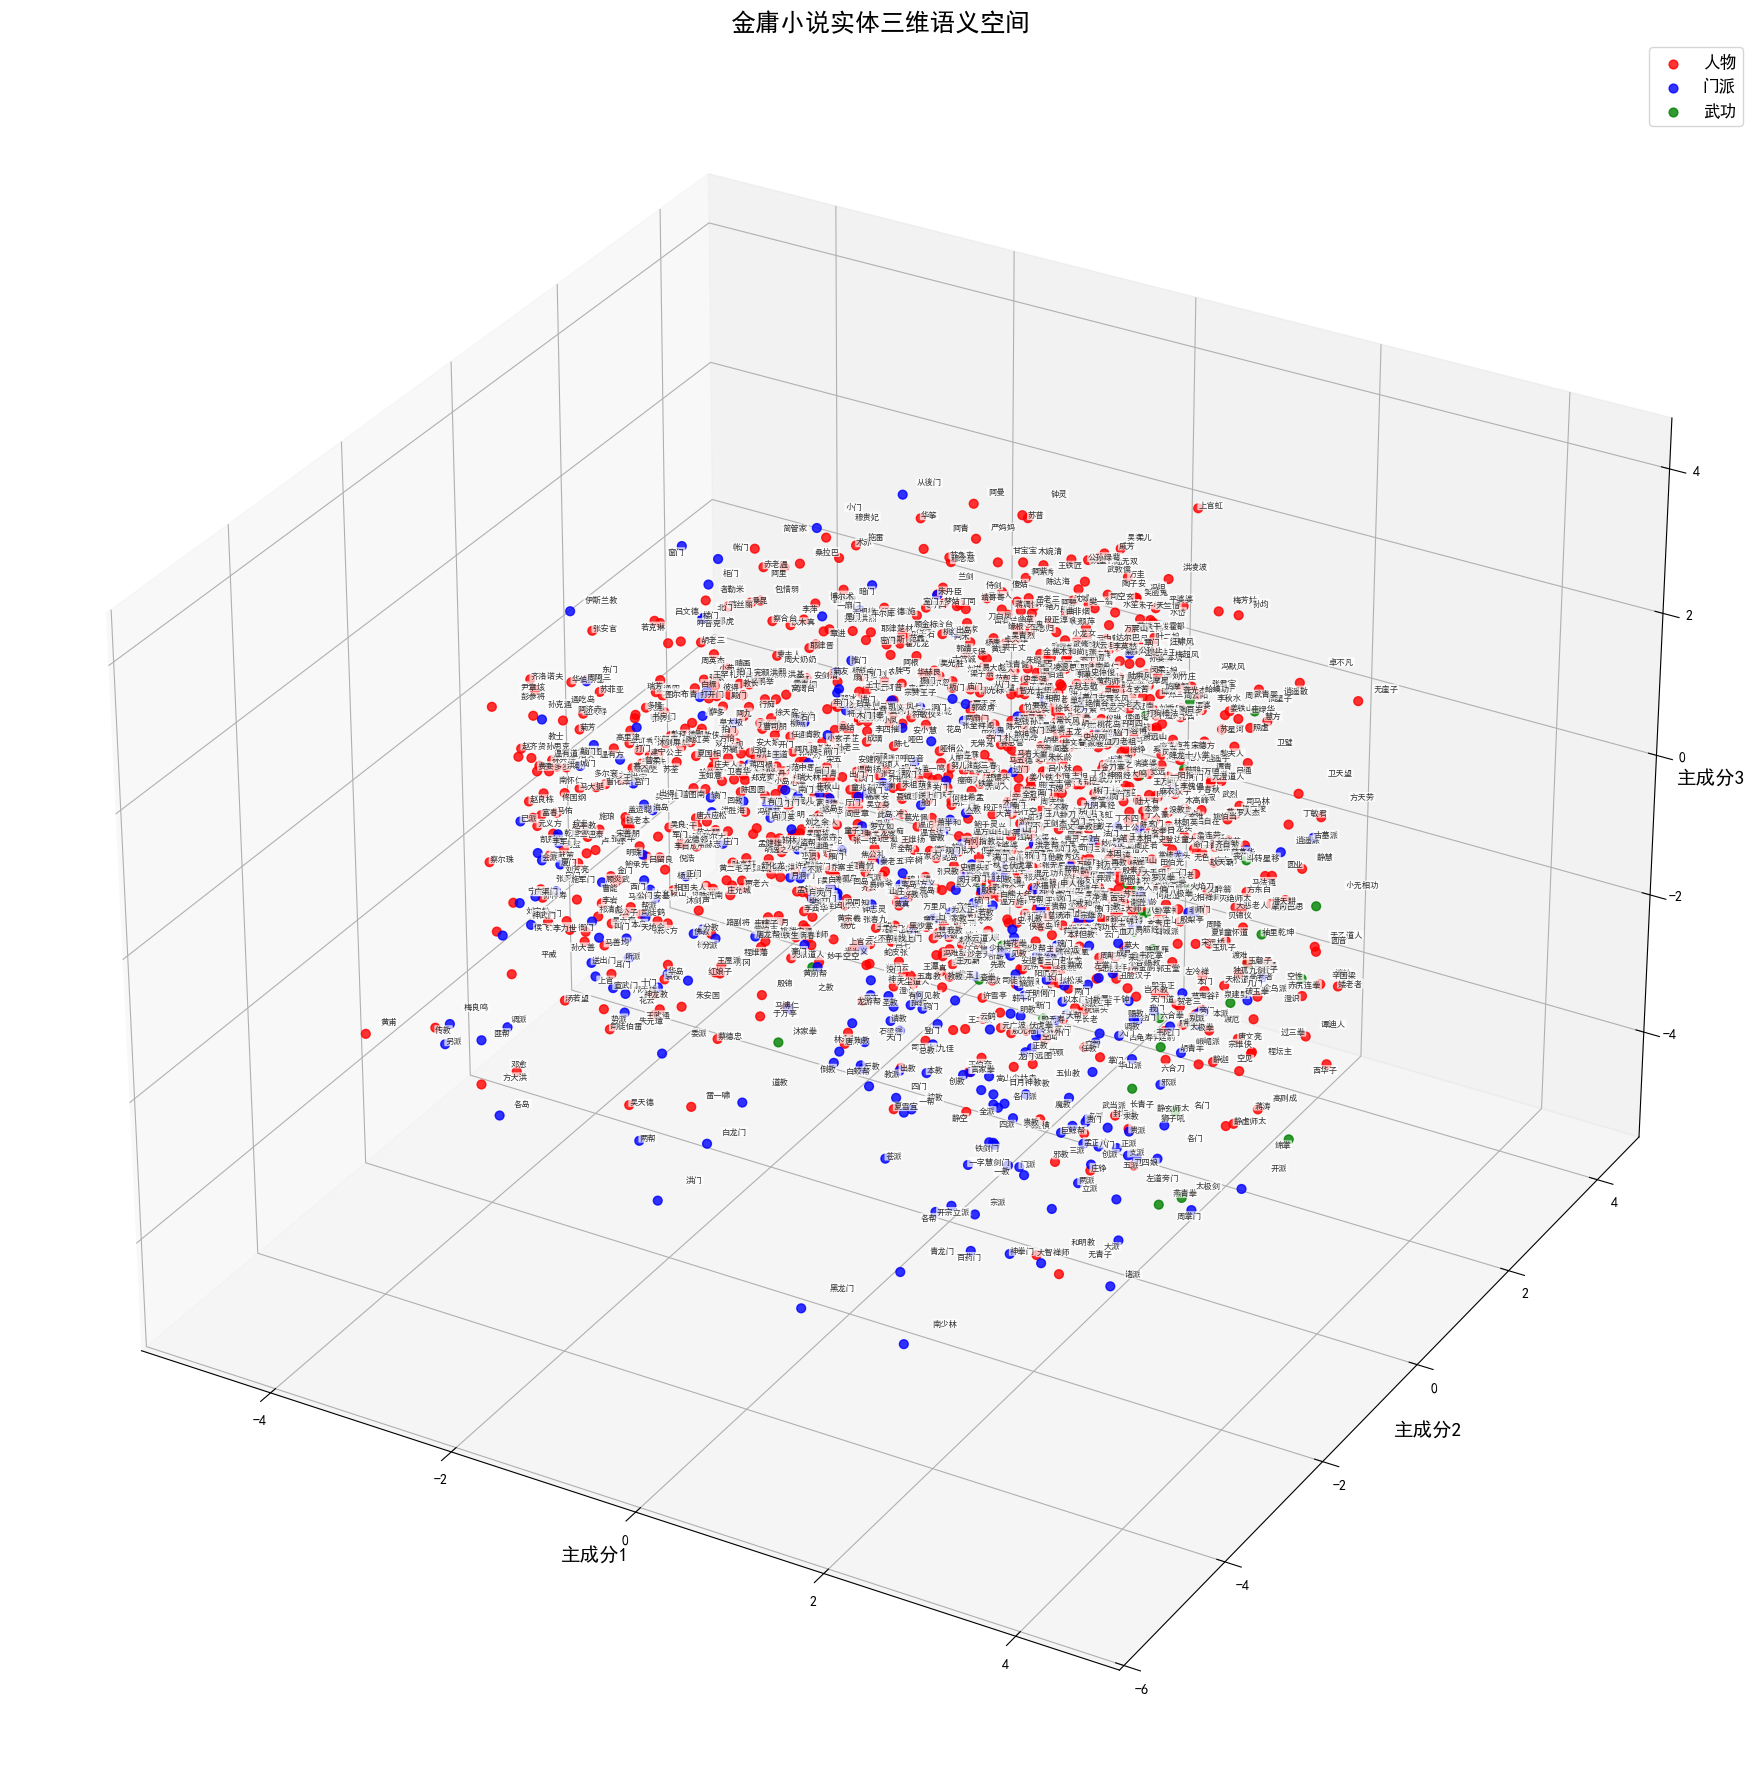

生成人物-门派子图...
生成人物-武功子图...
生成门派-武功子图...


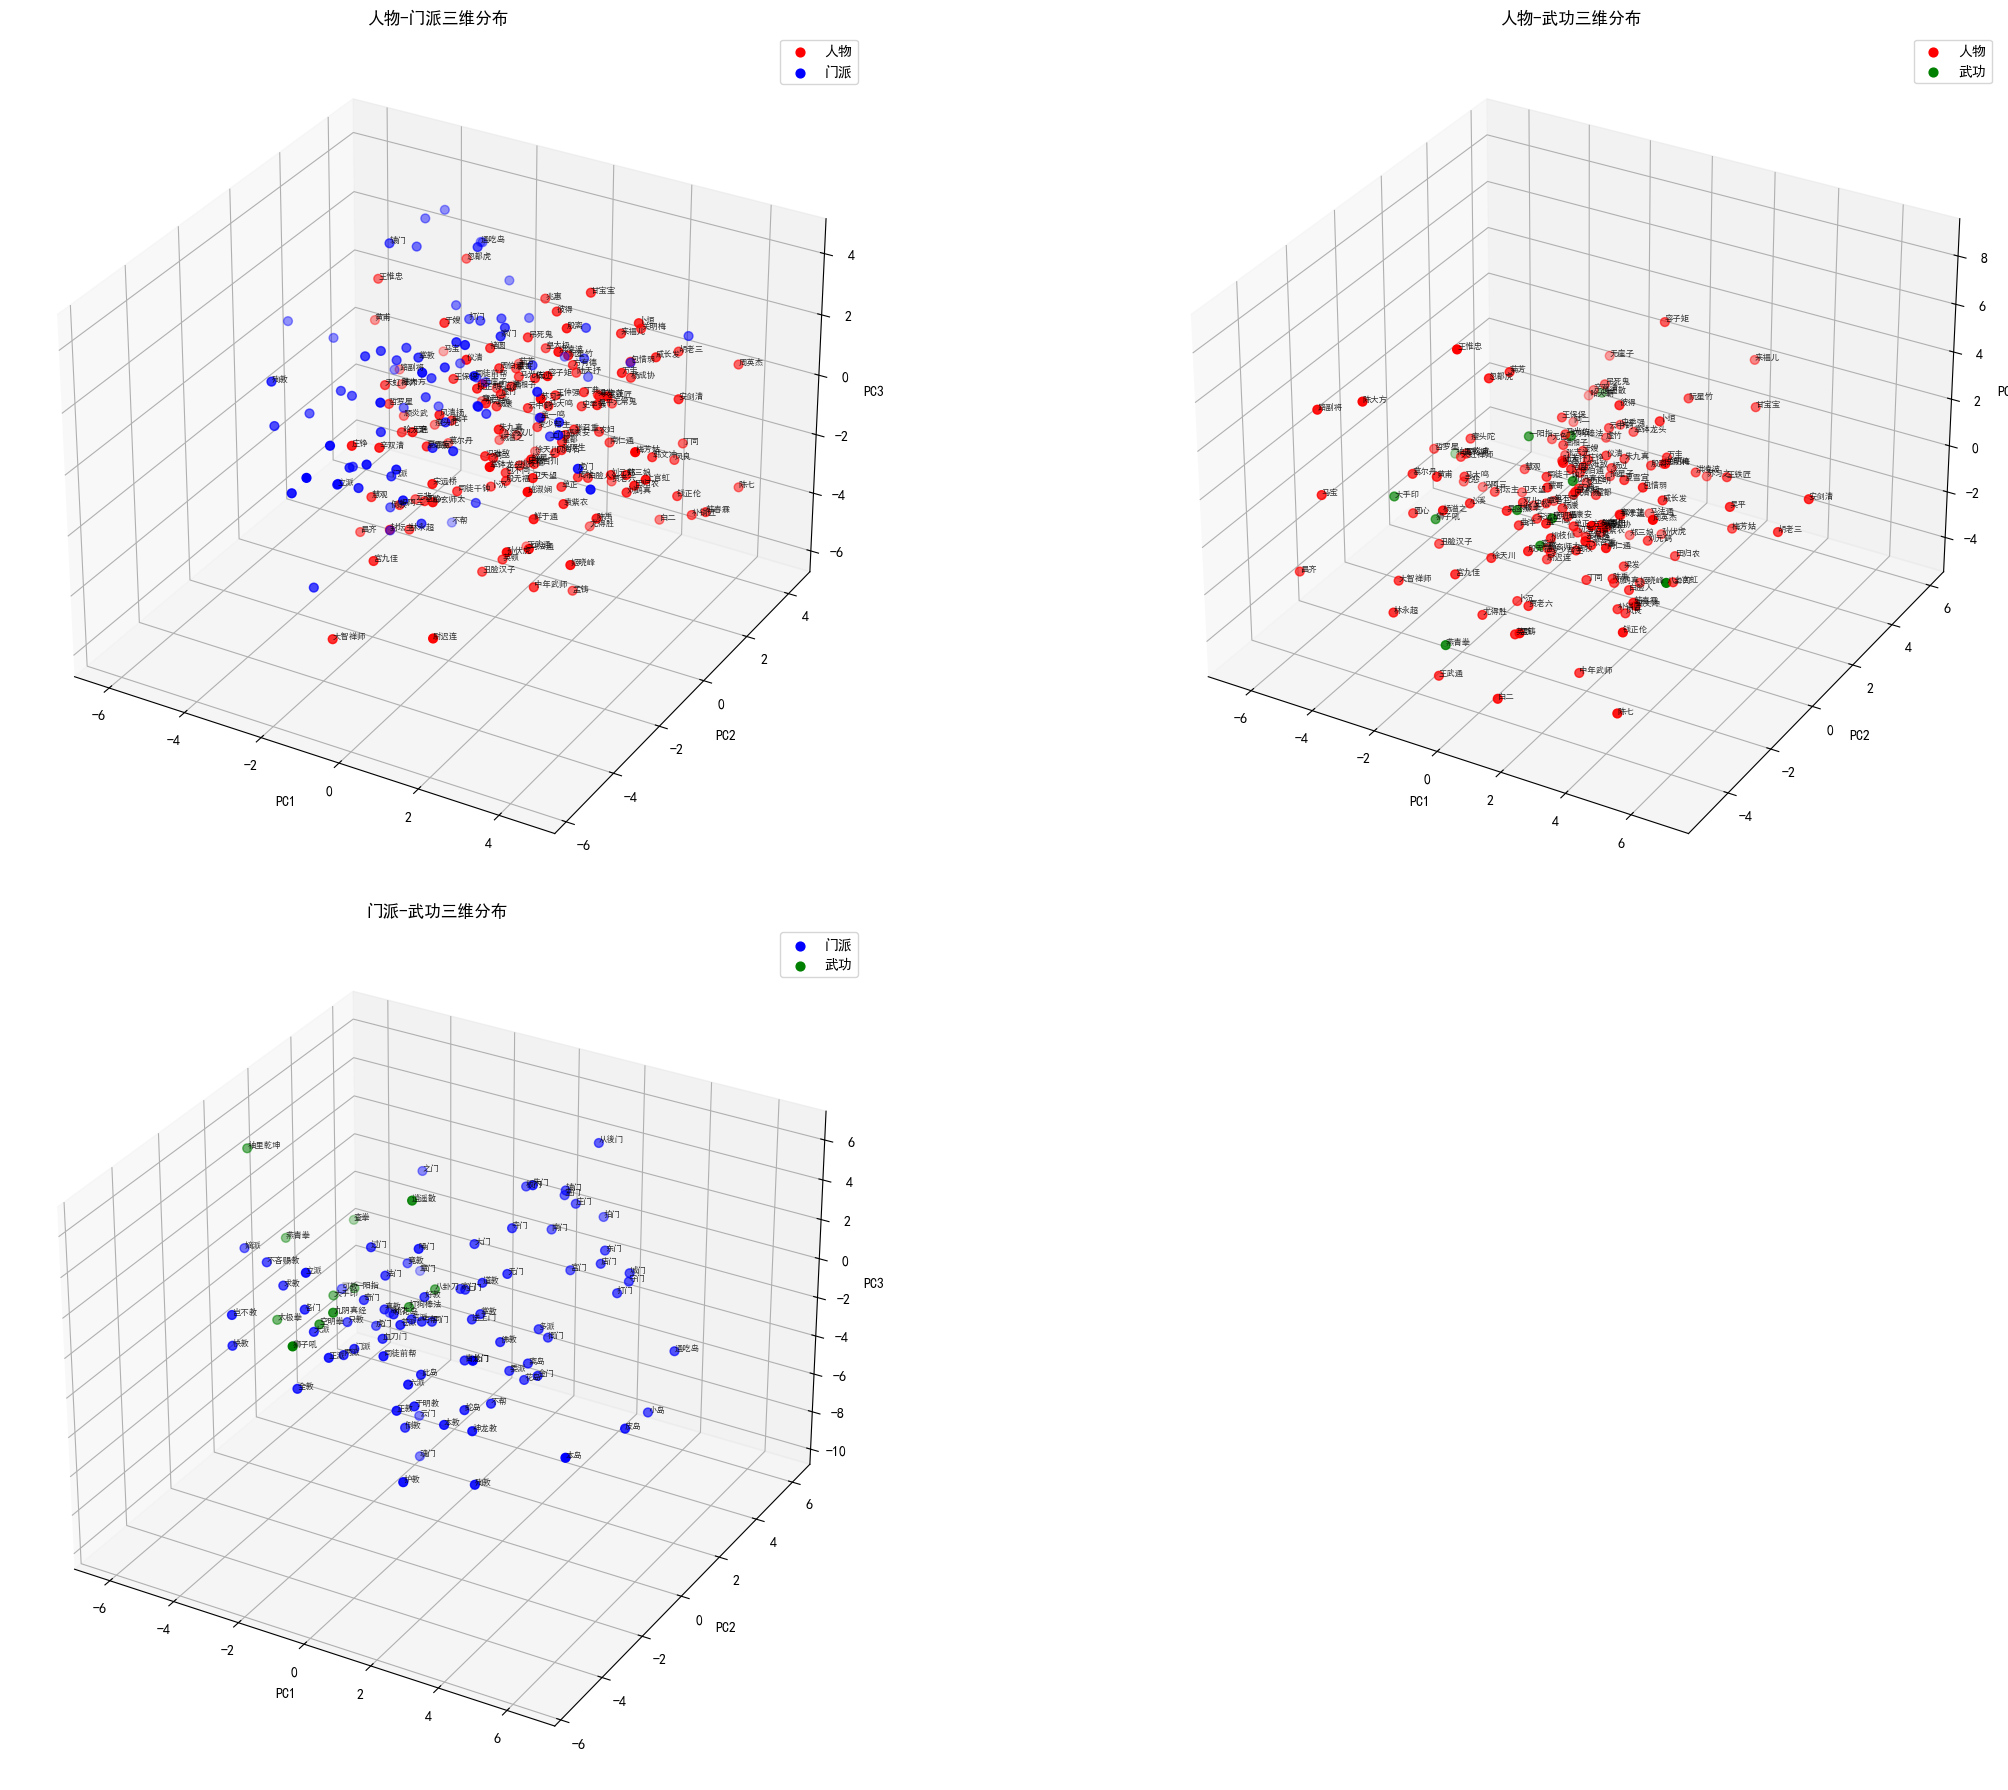

In [6]:
# ===== 新增子图可视化实现 =====
class MultiPCAVisualizer(PCAVisualizer):
    def visualize_all_combinations(self, persons, orgs, skills):
        """生成综合图和三个两两组合子图"""
        # 原始综合图
        print("生成综合三维可视化...")
        self.visualize_3d(persons, orgs, skills)
        
        # 创建组合图
        fig = plt.figure(figsize=(24, 18))
        plt.subplots_adjust(wspace=0.15, hspace=0.2)
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        
        # 人物-门派子图
        print("生成人物-门派子图...")
        ax1 = fig.add_subplot(2, 2, 1, projection='3d')
        self._plot_pair(ax1, persons, orgs, 'red', 'blue', '人物-门派三维分布')
        
        # 人物-武功子图
        print("生成人物-武功子图...")
        ax2 = fig.add_subplot(2, 2, 2, projection='3d')
        self._plot_pair(ax2, persons, skills, 'red', 'green', '人物-武功三维分布')
        
        # 门派-武功子图
        print("生成门派-武功子图...")
        ax3 = fig.add_subplot(2, 2, 3, projection='3d')
        self._plot_pair(ax3, orgs, skills, 'blue', 'green', '门派-武功三维分布')
        
        plt.tight_layout()
        plt.show()

    def _plot_pair(self, ax, group1, group2, color1, color2, title):
        """通用子图绘制方法"""
        # 数据预处理
        group1 = list(group1)[:self.config['visual_topn']]
        group2 = list(group2)[:self.config['visual_topn']]
        emb1, words1 = self.get_embeddings(group1)
        emb2, words2 = self.get_embeddings(group2)
        
        # 合并数据
        all_emb = np.concatenate([emb1, emb2])
        all_words = words1 + words2
        colors = [color1]*len(words1) + [color2]*len(words2)
        
        # PCA降维
        pca = PCA(n_components=3)
        points = pca.fit_transform(all_emb)
        
        # 绘制散点
        ax.scatter(points[:len(words1),0], points[:len(words1),1], points[:len(words1),2],
                   c=color1, label='人物' if color1 == 'red' else '门派', s=self.config['marker_size'])
        ax.scatter(points[len(words1):,0], points[len(words1):,1], points[len(words1):,2],
                   c=color2, label='武功' if color2 == 'green' else '门派', s=self.config['marker_size'])
        
        # 添加标签
        for i, (x,y,z,word) in enumerate(zip(points[:,0], points[:,1], points[:,2], all_words)):
            if i < self.config['visual_topn']:
                ax.text(x, y, z, word, fontsize=self.config['label_fontsize']-2,
                        color='black', alpha=0.8, zorder=10)
        
        # 设置属性
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title(title)
        ax.legend()

if LOAD_CHECKPOINT:

    # 新增组合可视化
    multi_visualizer = MultiPCAVisualizer(CONFIG, model, vocab, data_loader.entity_data)
    multi_visualizer.visualize_all_combinations(persons, orgs, skills)

# 6.二维可视化模块


======================================== 开始二维可视化 ========================================
生成综合二维可视化...


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


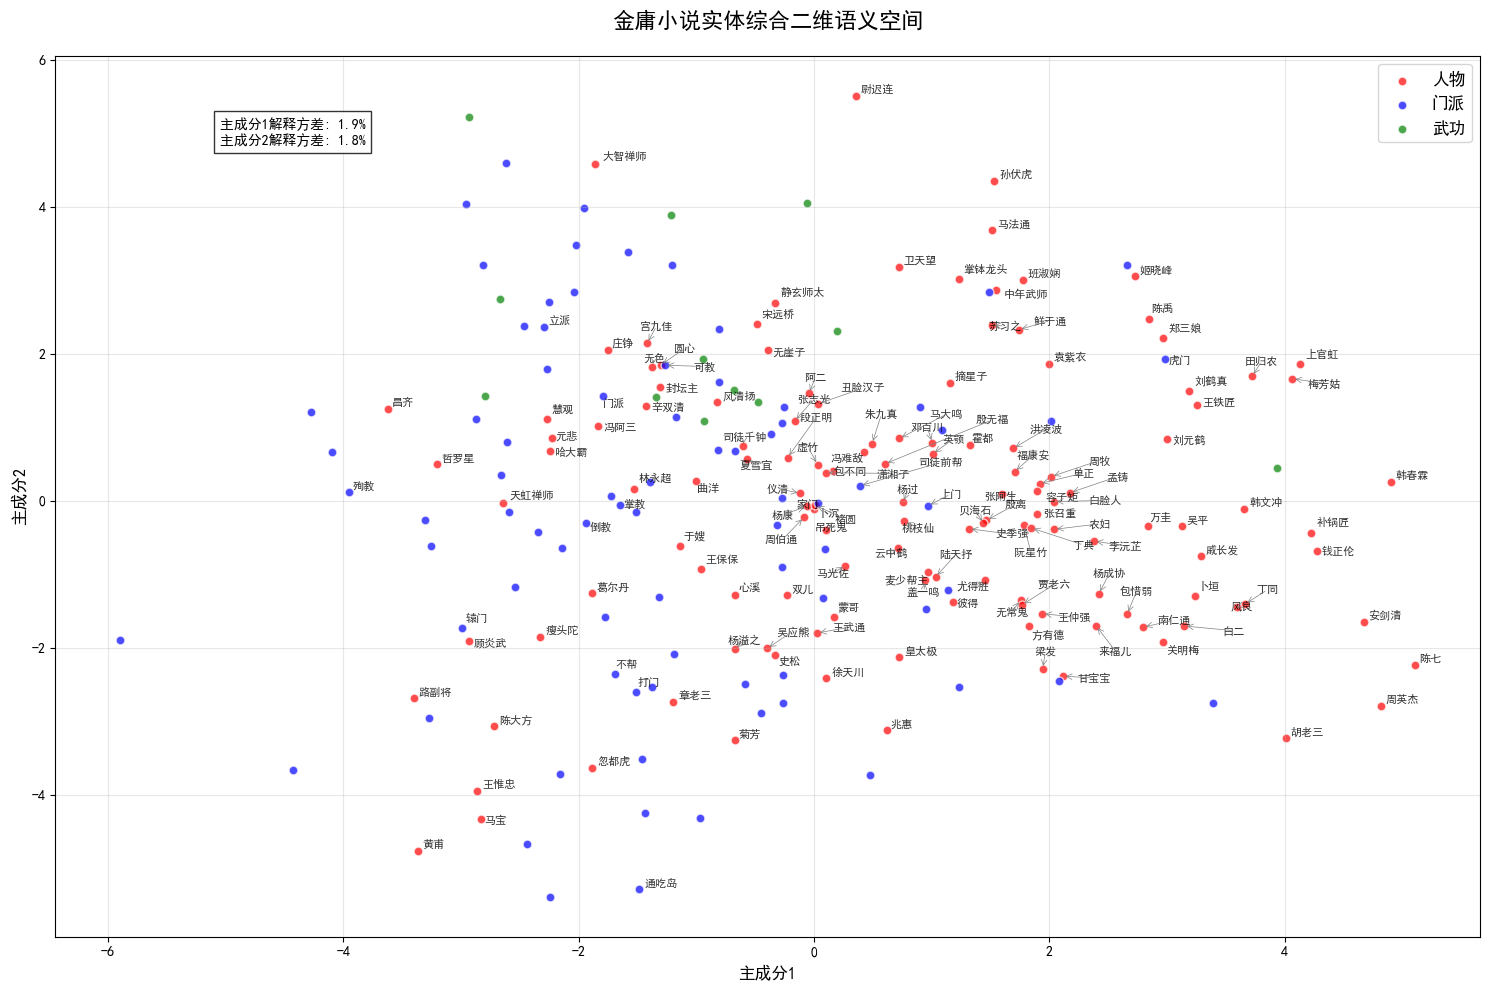

生成人物-门派二维子图...
生成人物-武功二维子图...
生成门派-武功二维子图...


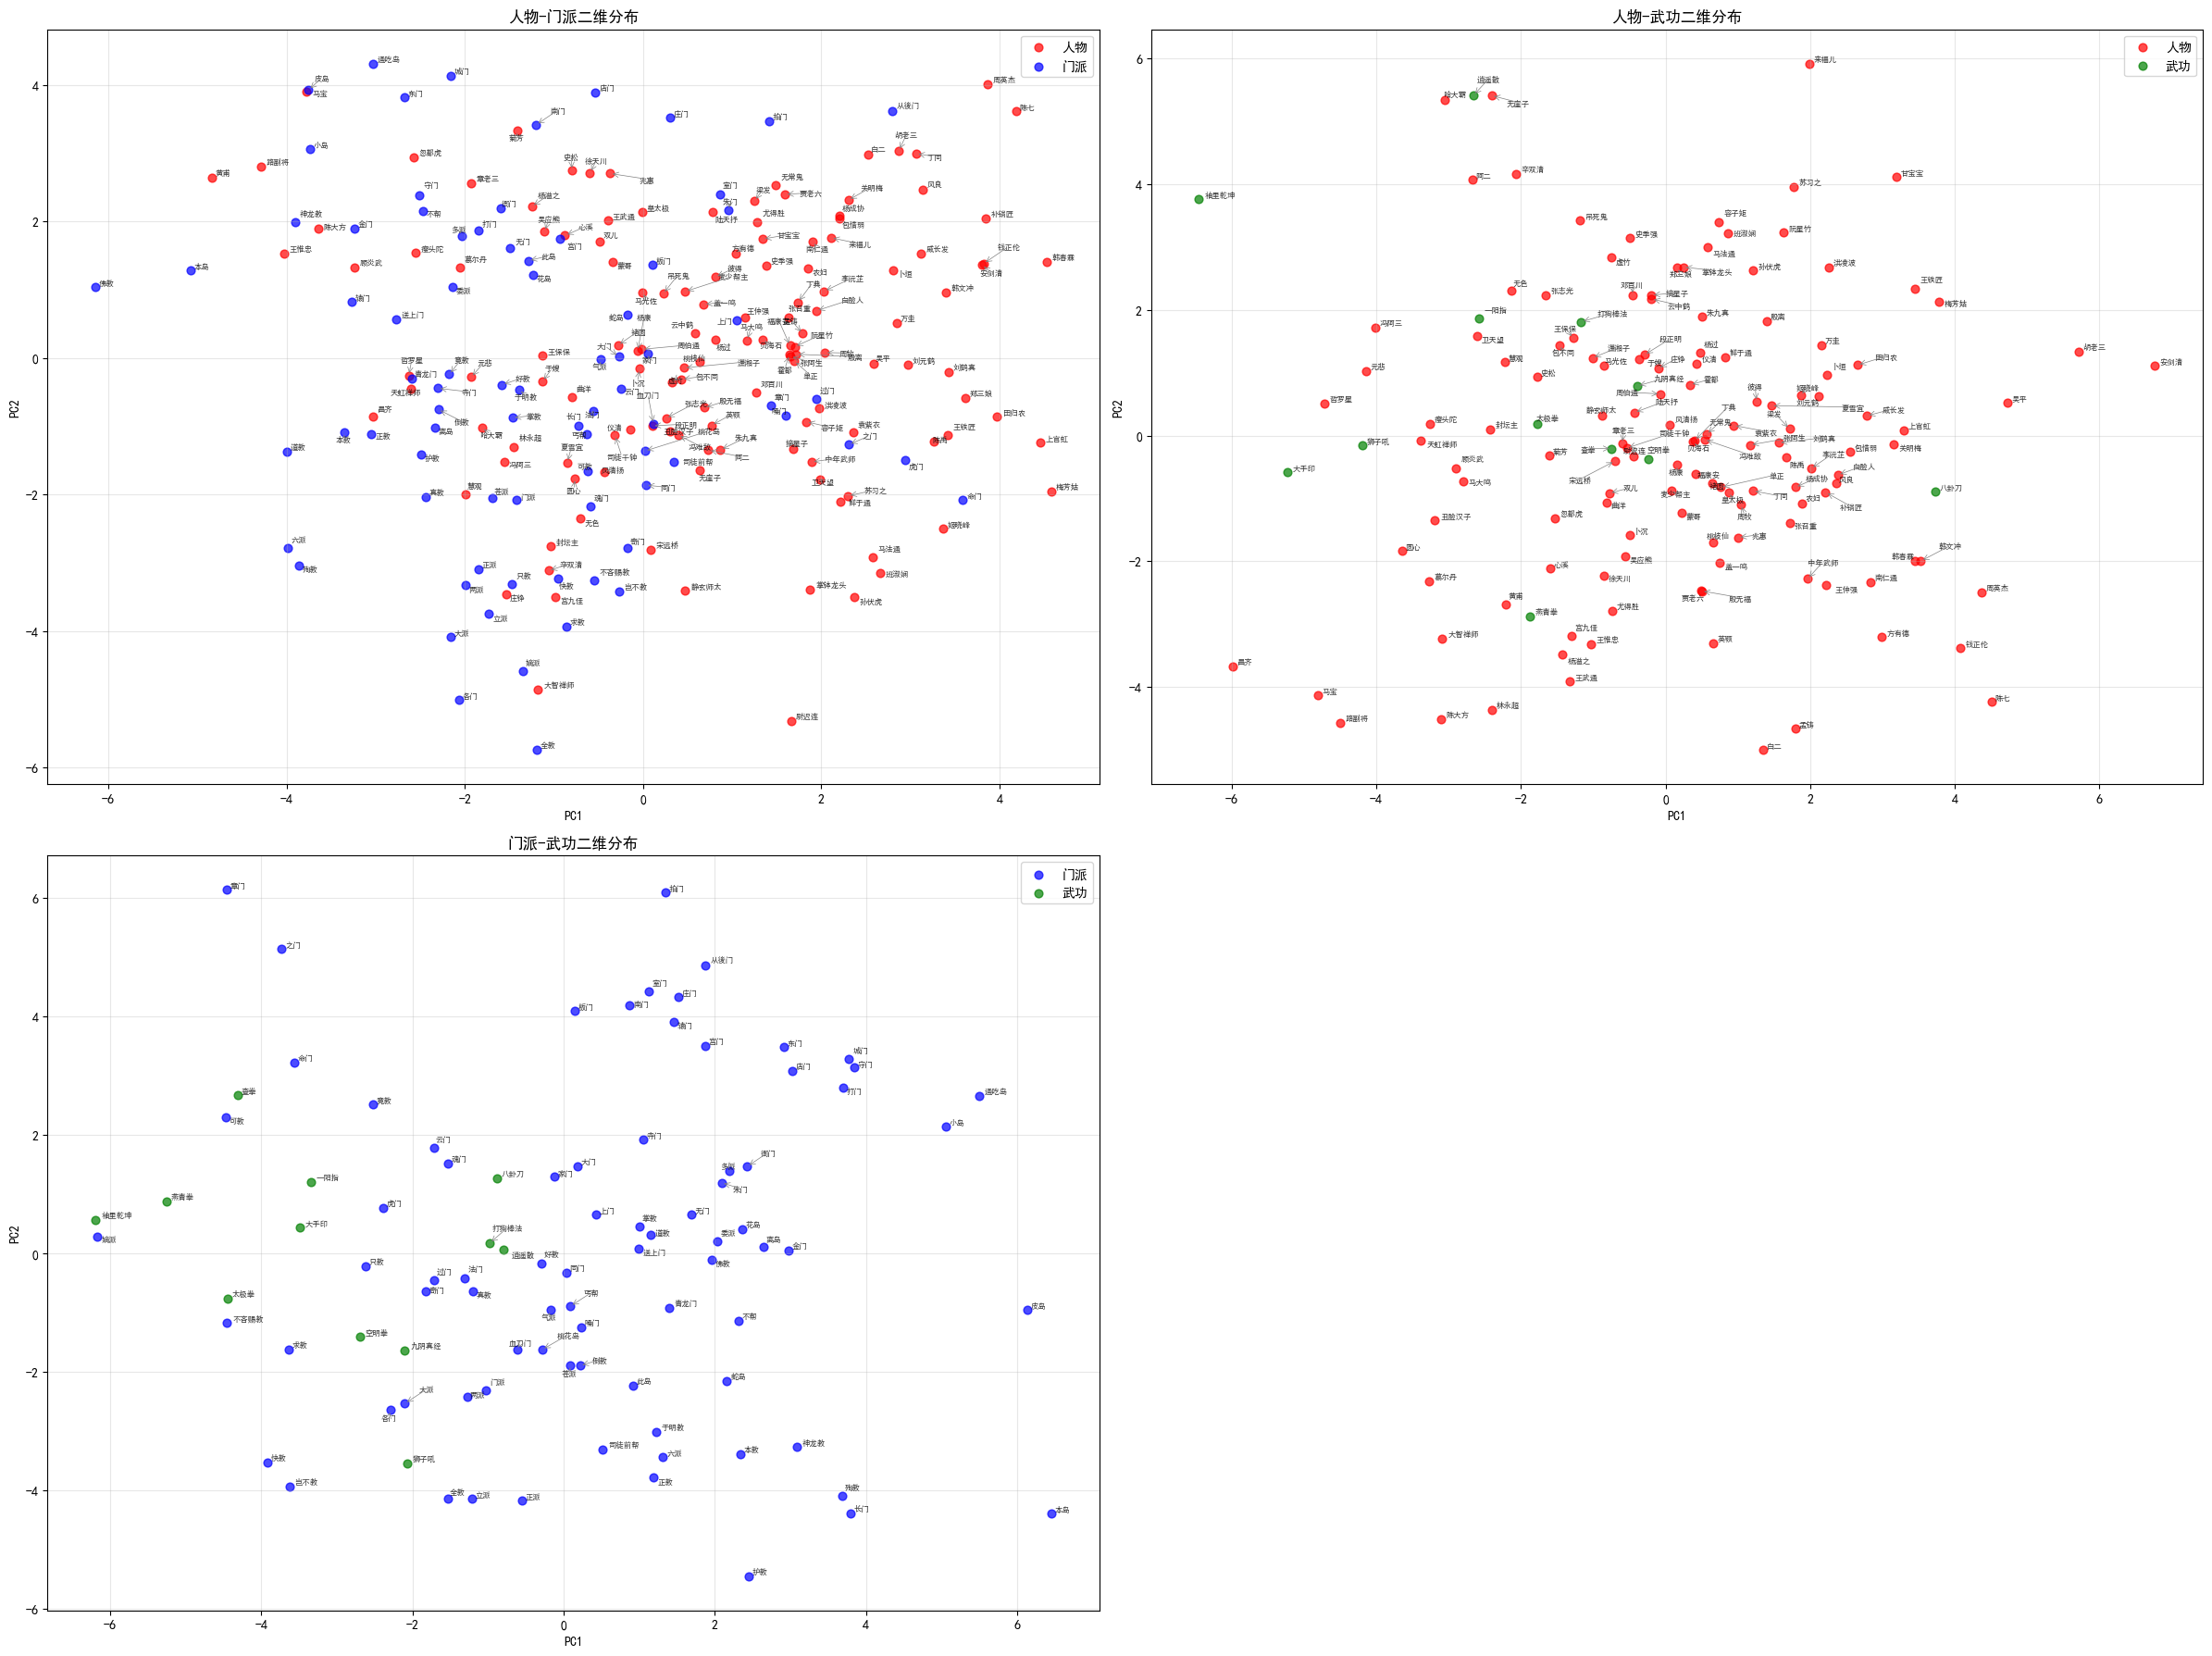

In [7]:
# ===== 修改后的二维可视化实现 =====
print("\n" + "="*40 + " 开始二维可视化 " + "="*40)

class PCA2DVisualizer(PCAVisualizer):
    def visualize_all_combinations(self, persons, orgs, skills):
        """生成综合二维图和三个两两组合子图"""
        # 生成综合二维图
        print("生成综合二维可视化...")
        self.visualize_2d_combined(persons, orgs, skills)
        
        # 创建组合子图
        fig = plt.figure(figsize=(24, 18))
        plt.subplots_adjust(wspace=0.15, hspace=0.2)
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        
        # 人物-门派子图
        print("生成人物-门派二维子图...")
        ax1 = fig.add_subplot(2, 2, 1)
        self._plot_pair_2d(ax1, persons, orgs, 'red', 'blue', '人物-门派二维分布')
        
        # 人物-武功子图
        print("生成人物-武功二维子图...")
        ax2 = fig.add_subplot(2, 2, 2)
        self._plot_pair_2d(ax2, persons, skills, 'red', 'green', '人物-武功二维分布')
        
        # 门派-武功子图
        print("生成门派-武功二维子图...")
        ax3 = fig.add_subplot(2, 2, 3)
        self._plot_pair_2d(ax3, orgs, skills, 'blue', 'green', '门派-武功二维分布')
        
        plt.tight_layout()
        plt.show()

    def visualize_2d_combined(self, persons, orgs, skills):
        """生成包含所有三类实体的综合二维图"""
        # 限制显示数量
        persons = list(persons)[:self.config['visual_topn']]
        orgs = list(orgs)[:self.config['visual_topn']]
        skills = list(skills)[:self.config['visual_topn']]
        
        # 获取词向量
        emb_p, words_p = self.get_embeddings(persons)
        emb_o, words_o = self.get_embeddings(orgs)
        emb_s, words_s = self.get_embeddings(skills)
        
        # 合并数据
        all_emb = np.concatenate([emb_p, emb_o, emb_s])
        all_words = words_p + words_o + words_s
        colors = ['red']*len(words_p) + ['blue']*len(words_o) + ['green']*len(words_s)
        
        # 执行PCA降维到二维
        pca = PCA(n_components=2)
        points = pca.fit_transform(all_emb)
        
        # 创建可视化图形
        plt.figure(figsize=(15, 10))
        ax = plt.gca()
        
        # 绘制不同类别的散点
        scatter_p = ax.scatter(
            points[:len(words_p), 0], 
            points[:len(words_p), 1], 
            c='red', label='人物', 
            s=self.config['marker_size'],
            alpha=0.7,
            edgecolors='w'
        )
        scatter_o = ax.scatter(
            points[len(words_p):len(words_p)+len(words_o), 0], 
            points[len(words_p):len(words_p)+len(words_o), 1], 
            c='blue', label='门派', 
            s=self.config['marker_size'],
            alpha=0.7,
            edgecolors='w'
        )
        scatter_s = ax.scatter(
            points[-len(words_s):, 0], 
            points[-len(words_s):, 1], 
            c='green', label='武功', 
            s=self.config['marker_size'],
            alpha=0.7,
            edgecolors='w'
        )
        
        # 智能标签布局
        from adjustText import adjust_text
        texts = []
        for i, (x, y) in enumerate(points):
            if i < self.config['visual_topn']:
                texts.append(ax.text(x, y, all_words[i], 
                                   fontsize=self.config['label_fontsize'],
                                   alpha=0.8))
        adjust_text(texts, 
                   arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
                   force_text=0.85,
                   expand_points=(1.5, 1.5))
        
        # 设置图表属性
        ax.set_xlabel('主成分1', fontsize=12)
        ax.set_ylabel('主成分2', fontsize=12)
        plt.title('金庸小说实体综合二维语义空间', fontsize=16, pad=20)
        plt.legend(handles=[scatter_p, scatter_o, scatter_s], 
                 loc='upper right',
                 fontsize=12)
        
        # 添加方差解释率
        var_ratio = pca.explained_variance_ratio_
        plt.figtext(0.15, 0.85, 
                   f"主成分1解释方差: {var_ratio[0]*100:.1f}%\n主成分2解释方差: {var_ratio[1]*100:.1f}%",
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    def _plot_pair_2d(self, ax, group1, group2, color1, color2, title):
        """二维子图绘制方法"""
        # 数据预处理
        group1 = list(group1)[:self.config['visual_topn']]
        group2 = list(group2)[:self.config['visual_topn']]
        emb1, words1 = self.get_embeddings(group1)
        emb2, words2 = self.get_embeddings(group2)
        
        # 合并数据
        all_emb = np.concatenate([emb1, emb2])
        all_words = words1 + words2
        colors = [color1]*len(words1) + [color2]*len(words2)
        
        # PCA降维
        pca = PCA(n_components=2)
        points = pca.fit_transform(all_emb)
        
        # 绘制散点
        ax.scatter(points[:len(words1),0], points[:len(words1),1],
                   c=color1, label='人物' if color1 == 'red' else '门派', 
                   s=self.config['marker_size'], alpha=0.7)
        ax.scatter(points[len(words1):,0], points[len(words1):,1],
                   c=color2, label='武功' if color2 == 'green' else '门派', 
                   s=self.config['marker_size'], alpha=0.7)
        
        # 智能标签布局
        texts = []
        for i, (x,y) in enumerate(points):
            texts.append(ax.text(x, y, all_words[i], 
                                fontsize=self.config['label_fontsize']-2,
                                color='black', alpha=0.8))
        
        from adjustText import adjust_text
        adjust_text(texts, ax=ax,
                   arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
                   force_text=0.85,
                   expand_points=(1.5, 1.5))
        
        # 设置属性
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title(title)
        ax.legend()
        ax.grid(alpha=0.3)

# 使用示例（与三维版本保持相同接口）
if LOAD_CHECKPOINT:
    visualizer_2d = PCA2DVisualizer(CONFIG, model, vocab, data_loader.entity_data)
else:
    visualizer_2d = PCA2DVisualizer(CONFIG, trainer.model, data_loader.vocab, data_loader.entity_data)
visualizer_2d.visualize_all_combinations(persons, orgs, skills)